# 프로젝트 : 폐렴 진단기 성능개선

### Step .1 실험환경 Set-up

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

Duplicate key in file PosixPath('/home/aiffel-dj12/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family:  sans-serif')


In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel-dj12/aiffel


### Step . 2 데이터 준비하기

#### 데이터 개수 확인 하기

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


#### train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


#### train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인 !

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1080
Pneumonia images count in training set: 3105


#### tf.data 인스턴스

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

#Train 데이터셋 validation 데이터 셋 수

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


#### 라벨이 따로 없어서 제목에 라벨 만들어주기 

In [8]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

#### 이미지 사이즈 변경 및 데이터 타입 변경

In [9]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

#### train 테이터 와 validation데이터 만들기 

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

#### 이미지 사이즈 및 라벨 확인 

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


#### test 데이터 셋 만들기

In [12]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


#### prepare_for_training함수는 학습 데이터를 효율적으로 할 수 있도록 데이터 변환

In [13]:
# def prepare_for_training(ds, shuffle_buffer_size=1000):

#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     # 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 요소 선택
#     ds = ds.repeat()
#     # epoch를 진행하면서 여러번 데이터셋을 불러오면서 
#     # repeat() 사용하면 여러번 데이터셋을 사용할수 있게 해줌 자동으로 데이터맞춤
#     ds = ds.batch(BATCH_SIZE)
#     # 위에 정한 BATCH사이즈로 해줌
#     ds = ds.prefetch(buffer_size=AUTOTUNE)
#     # 학습데이터를 나눠서 읽어옴 gpu학습동안 cpu에서 준비 함 
#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

#### augmentation 기법

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### Step . 3 데이터 시각화

#### 이미지 와 라벨 데이터 셋 나누고 시각화 

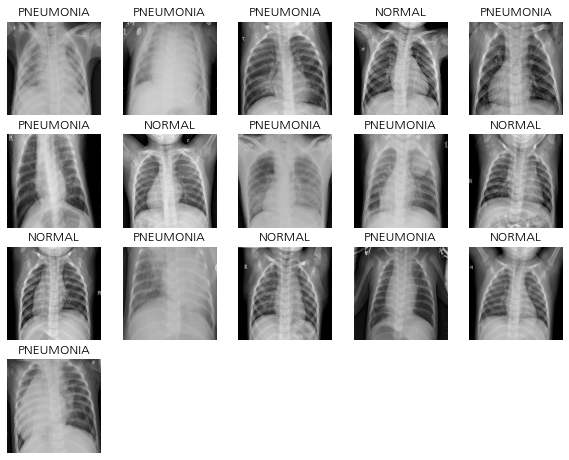

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

#### augmentation 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


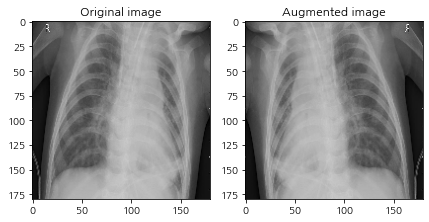

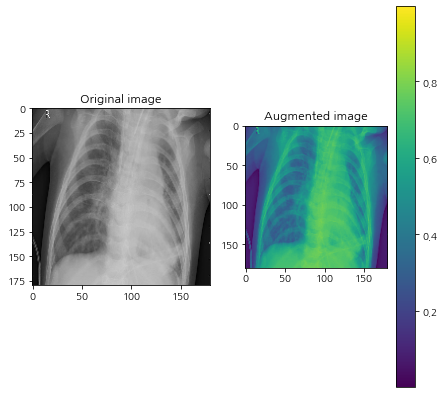

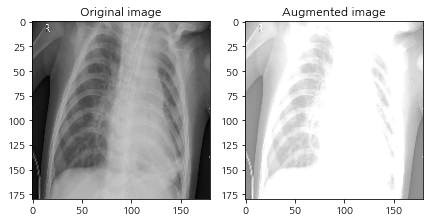

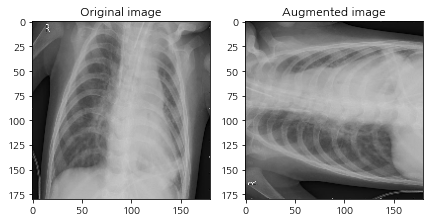

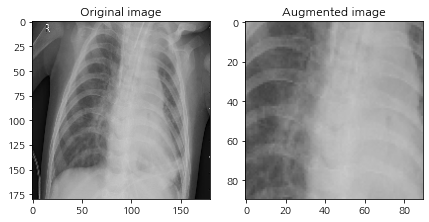

In [16]:
def visualize(original, augmented):
    plt.figure(figsize=(7,7))
    #fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

bright = tf.image.adjust_brightness(image, 0.5)
visualize(image, bright)

rotated = tf.image.rot90(image)
visualize(image, rotated)

cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

### Step . 4 CNN 모델링

#### 의료영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델구조 등을 다양하게 바꾸어볼 수 있습니다.

#### 그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
#### 이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

#### Convolution block 만들기

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

#### Dense Block 만들기

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

#### CNN모델 

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Step . 5 데이터 imbalance 처리

In [20]:
# weight_for_0은 'Normal' 이미지에 사용할 weight
# weight_for_1은 'Pneumonia' 이미지에 사용할 weight
# weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


### Step . 6 모델 훈련

#### loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다

In [22]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#### 모델 fit 

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 26s 98ms/step - loss: 0.3606 - accuracy: 0.8283 - precision: 0.9570 - recall: 0.8047 - val_loss: 0.6023 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 22s 84ms/step - loss: 0.2455 - accuracy: 0.9054 - precision: 0.9675 - recall: 0.9030 - val_loss: 1.4226 - val_accuracy: 0.7423 - val_precision: 0.7423 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 22s 84ms/step - loss: 0.2278 - accuracy: 0.9203 - precision: 0.9678 - recall: 0.9230 - val_loss: 0.1414 - val_accuracy: 0.9481 - val_precision: 0.9411 - val_recall: 0.9922
Epoch 4/25
261/261 [==============================] - 22s 84ms/step - loss: 0.2031 - accuracy: 0.9243 - precision: 0.9760 - recall: 0.9205 - val_loss: 0.0961 - val_accuracy: 0.9683 - val_precision: 0.9868 - val_recall: 0.9702
Epoch 5/25
261/261 [==============================] - 22s 84ms/step - loss: 0.1831 - accuracy: 0

### Step . 7 결과 확인과 시각화

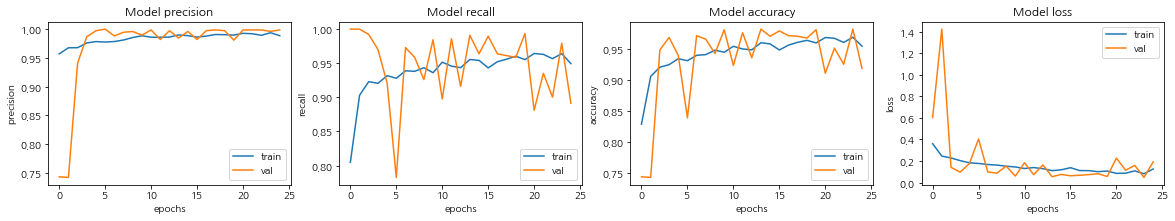

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

#### 모델 평가 

In [25]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 56ms/step - loss: 0.6578 - accuracy: 0.8622 - precision: 0.8439 - recall: 0.9564


# 프로젝트를 마치며..

#### 처음에 아무것도 건들지않고 모델 평가를 했을때 82% 정도의 결과가 나왔다 
####  augmentation를 사용 하여  accuracy 확인 해보니 88%으로 상승 했지만 여러가지 테스트를 해본 후 다시 평가 하니 86%가 되었다. 아마도 랜덤하게 좌우 반전을 한후 평가를 해서 그런지 돌릴때마다 정확도가 달라지는거 같다. 
#### imbalance 문제에 대처하기 위한 class_weight를 생략해보았고 85% 결과 도출
#### augmentation시도한걸 show_batch()함수에 넣어 표현하고 싶었지만 생각대로 되지않아 tf.image를 이용해서 좌우반전 과 다양한 시각화를 실습했다. 
#### 여유를 가지고 모델링을 해보고 면밀히 분석해보는 실력을 키워야 겠다. 